In [1]:
from qiskit import QuantumCircuit, QuantumRegister
import os, sys
import numpy
import random
from tqdm import tqdm
import rustworkx
import json
import matplotlib.pyplot as plt

if not '../' in sys.path:
    sys.path.insert(1, '../')

In [2]:
from helperfunctions.circuitgraphfunctions import get_computation_graph, get_uncomp_circuit
from helperfunctions.uncompfunctions import add_uncomputation, exhaustive_uncomputation_adding, greedy_uncomputation_full, greedy_uncomputation_partial
from helperfunctions.graphhelper import edge_attr, edge_matcher,node_attr,node_matcher, breakdown_qubit
from helperfunctions.measurecircuit import get_statevector, get_probability_from_statevector, zero_ancillas_in_statevector
from helperfunctions.constants import UncompType
from helperfunctions.randomcircuit import random_quantum_circuit_large_with_params

from rustworkx.visualization import graphviz_draw

In [3]:
# Built-in modules
import math

# Imports from Qiskit
from qiskit import QuantumCircuit
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.visualization import plot_distribution

# Imports from Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler

In [4]:
def grover_oracle(marked_states):
    """Build a Grover oracle for multiple marked states

    Here we assume all input marked states have the same number of bits

    Parameters:
        marked_states (str or list): Marked states of oracle

    Returns:
        QuantumCircuit: Quantum circuit representing Grover oracle
    """
    if not isinstance(marked_states, list):
        marked_states = [marked_states]
    # Compute the number of qubits in circuit
    num_qubits = len(marked_states[0])

    qc = QuantumCircuit(num_qubits)
    # Mark each target state in the input list
    for target in marked_states:
        # Flip target bit-string to match Qiskit bit-ordering
        rev_target = target[::-1]
        # Find the indices of all the '0' elements in bit-string
        zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)]
        # Add a multi-controlled Z-gate with pre- and post-applied X-gates (open-controls)
        # where the target bit-string has a '0' entry
        qc.x(zero_inds)
        qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)
        qc.x(zero_inds)
    return qc

['0101110', '1101100', '0111011']


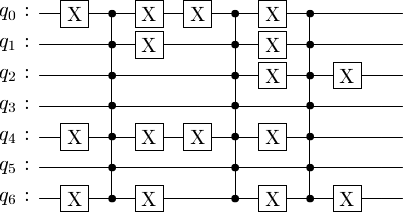

In [5]:
num_qubits = 7
num_masked_states=3
marked_states = [format(random.getrandbits(7), '0b').zfill(7) for i in range(num_masked_states)]
print(marked_states)

oracle = grover_oracle(marked_states)
oracle.draw(output="latex")

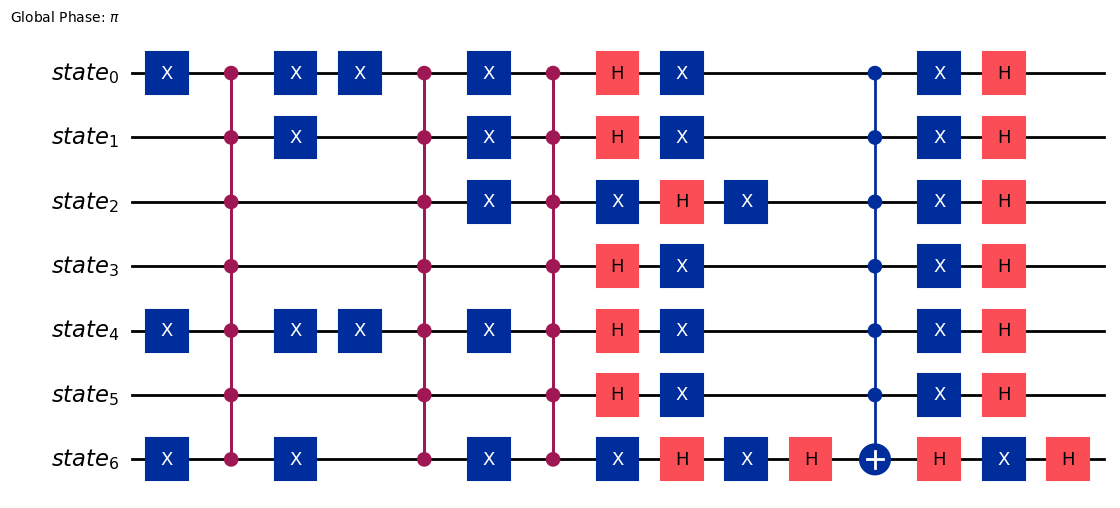

In [6]:
grover_op = GroverOperator(oracle)
grover_op.decompose().draw(output="mpl", style="iqp")

In [7]:
optimal_num_iterations = math.floor(
    math.pi / (4 * math.asin(math.sqrt(len(marked_states) / 2**grover_op.num_qubits)))
)

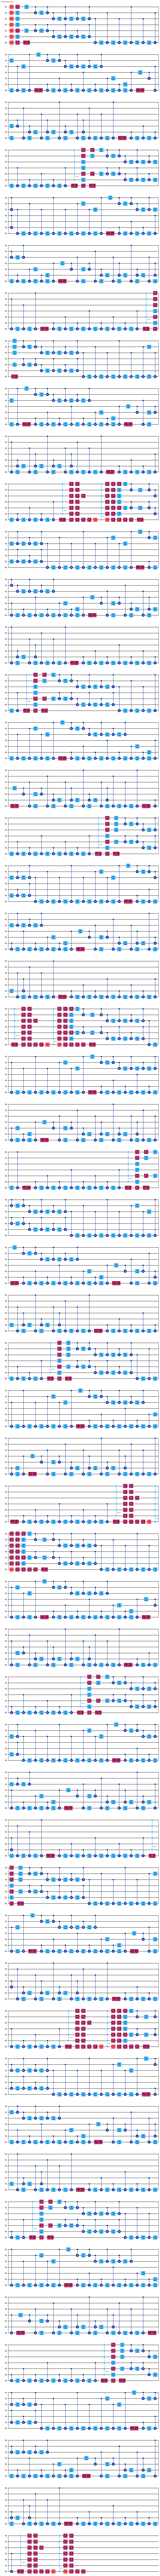

In [8]:
qc = QuantumCircuit(grover_op.num_qubits)
# Create even superposition of all basis states
qc.h(range(grover_op.num_qubits))
# Apply Grover operator the optimal number of times
qc.compose(grover_op.power(optimal_num_iterations).decompose().decompose().decompose(), inplace=True)
# Measure all qubits
# qc.measure_all()
qc.draw(output="mpl", style="iqp")